# Hourly Energy Consumption Playground Notebook

Data - Hourly energy consumption (energy consuption for various regions for a portion of the country in megawatts); obtained from Kaggle

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from dateutil.easter import easter

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [106]:
df = pd.read_csv("AEP_hourly.csv")
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [107]:
# Let's see the date range
print("Start Date: ", df["Datetime"].min())
print(" ")
print("End Date: ", df["Datetime"].max())

Start Date:  2004-10-01 01:00:00
 
End Date:  2018-08-03 00:00:00


In [108]:
df.shape

(121273, 2)

In [109]:
# Reindex
df = df.set_index("Datetime")
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


<Axes: xlabel='Datetime'>

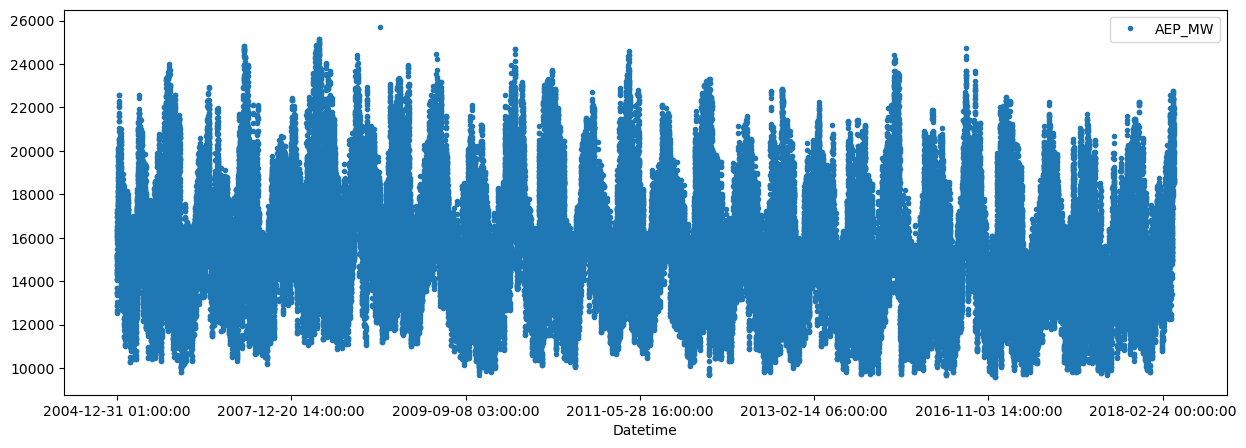

In [110]:
df.plot(style=".", figsize=(15, 5))

In [111]:
# Right now the Datetime dtype is "object"
# In order to continue, we want to convert it to "datetime"
df.index

Index(['2004-12-31 01:00:00', '2004-12-31 02:00:00', '2004-12-31 03:00:00',
       '2004-12-31 04:00:00', '2004-12-31 05:00:00', '2004-12-31 06:00:00',
       '2004-12-31 07:00:00', '2004-12-31 08:00:00', '2004-12-31 09:00:00',
       '2004-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=121273)

In [112]:
# The date is an object. Want to turn it into datetime
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

<Axes: xlabel='Datetime'>

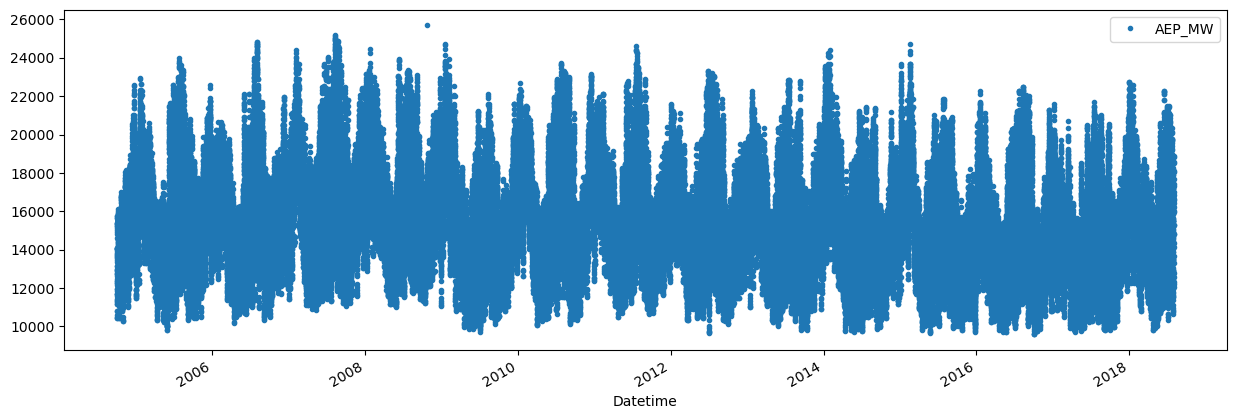

In [113]:
# Replot same plot from above since the y-axis should look cleaner now
df.plot(style=".", figsize=(15, 5))

<Axes: title={'center': 'One Week Data Segment'}, xlabel='Datetime'>

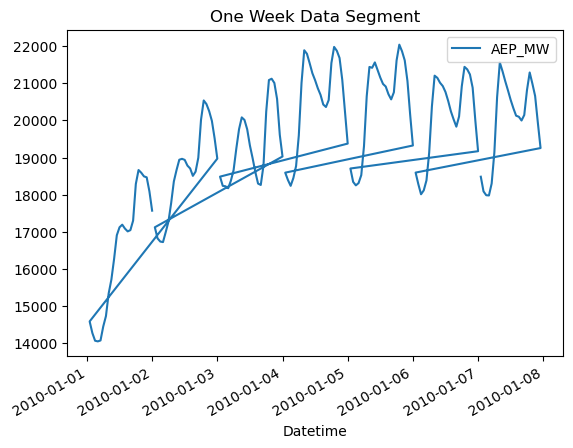

In [114]:
# Plot just one week so we can see the trend on a smaller scale
df.loc[(df.index > "01-01-2010") & (df.index < "01-08-2010")].plot(
    title="One Week Data Segment"
)

### Train/Test Split

We can now start getting ready for training. Since time series data is order dependent, the train/test split can't be randomized like it would be for non time-series data. This means that our 80/20 split has to happen chronologically along the Datetime.

In [115]:
train = df.loc[df.index < "01-01-2016"]
test = df.loc[df.index >= "01-01-2016"]

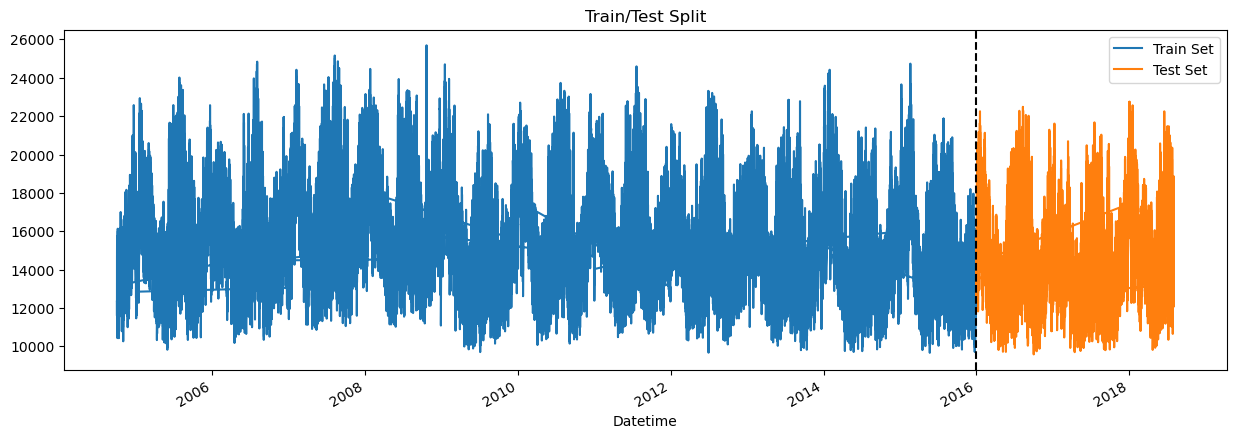

In [116]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Train", title="Train/Test Split")
test.plot(ax=ax, label="Test")
ax.axvline("01-01-2016", color="black", ls="--")
ax.legend(["Train Set", "Test Set"])
plt.show()

### Feature Creation

We want to extract some more features from the datetime so that we can have a more accurate pattern recognition. Facebook's Prophet library has this as a built in feature, however I find it to be less tonable than the traditional approaches so I will not be using it in the initial approach.

In [119]:
def feature_extraction(df):
    """
    Create new features from datetime, including regular intervals and holidays.
    Since Halloween and 4th of July are big party holidays, they often tend to be celebrated
    not only on the actual day, but also on the nearest weekends surrounding them. We will make
    sure to include these weekends and count them the same as the actual Holiday
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["day_of_year"] = df.index.dayofyear
    df["day"] = df.index.day

    # Create holiday features
    df["christmas"] = ((df["month"] == 12) & (df["day"] == 25)).astype(int)
    df["halloween"] = ((df["month"] == 10) & (df["day"] == 31)).astype(int)
    df["fourth_of_july"] = ((df["month"] == 7) & (df["day"] == 4)).astype(int)

    # Find nearest weekends to Halloween and 4th of July
    for holiday, col_name in [
        ("Halloween", "halloween"),
        ("4th of July", "fourth_of_july"),
    ]:
        holiday_dates = df[df[col_name] == 1].index
        for date in holiday_dates:
            if date.weekday() not in [5, 6]:
                prior_saturday = (
                    date - pd.Timedelta(days=date.weekday() + 1)
                    if date.weekday() >= 5
                    else date - pd.Timedelta(days=date.weekday() + 1)
                )
                upcoming_sunday = date + pd.Timedelta(days=(6 - date.weekday()))

                if prior_saturday in df.index:
                    df.loc[prior_saturday, col_name] = 1
                if upcoming_sunday in df.index:
                    df.loc[upcoming_sunday, col_name] = 1

    # Figure out Thanksgiving as the fourth Thursday of November
    df["thanksgiving"] = (
        (df["month"] == 11)
        & (df["day_of_week"] == 3)
        & (df["day"] >= 22)
        & (df["day"] <= 28)
    ).astype(int)

    # Easter varies per year, so we will use a library
    df["easter_date"] = df["year"].apply(lambda year: easter(year))
    df["easter"] = (df.index.date == df["easter_date"]).astype(int)

    # Drop helper column
    df.drop(columns=["easter_date"], inplace=True)

    return df

In [120]:
df = feature_extraction(df)
df.head()

,AEP_MW,hour,day_of_week,quarter,month,year,day_of_year,day,christmas,halloween,fourth_of_july,thanksgiving,easter
Datetime,,,,,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,31,0,0,0,0,0
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,31,0,0,0,0,0
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,31,0,0,0,0,0
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,31,0,0,0,0,0
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,31,0,0,0,0,0


Text(0.5, 1.0, 'Usage by Hour')

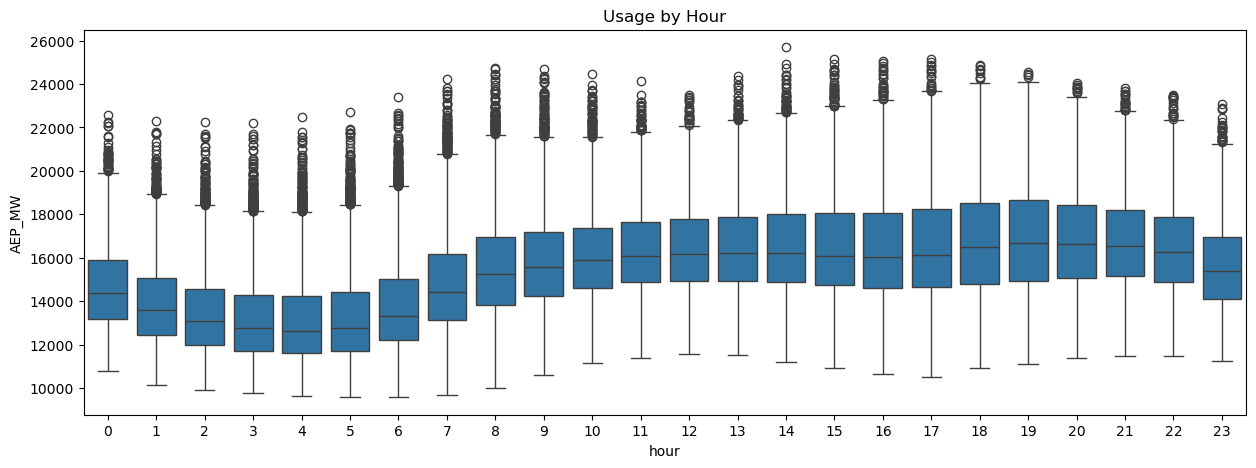

In [121]:
# Now that we extracted specific features, we can check out some more specific usage patterns
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x="hour", y="AEP_MW")
ax.set_title("Usage by Hour")

Text(0.5, 1.0, 'Usage by Month')

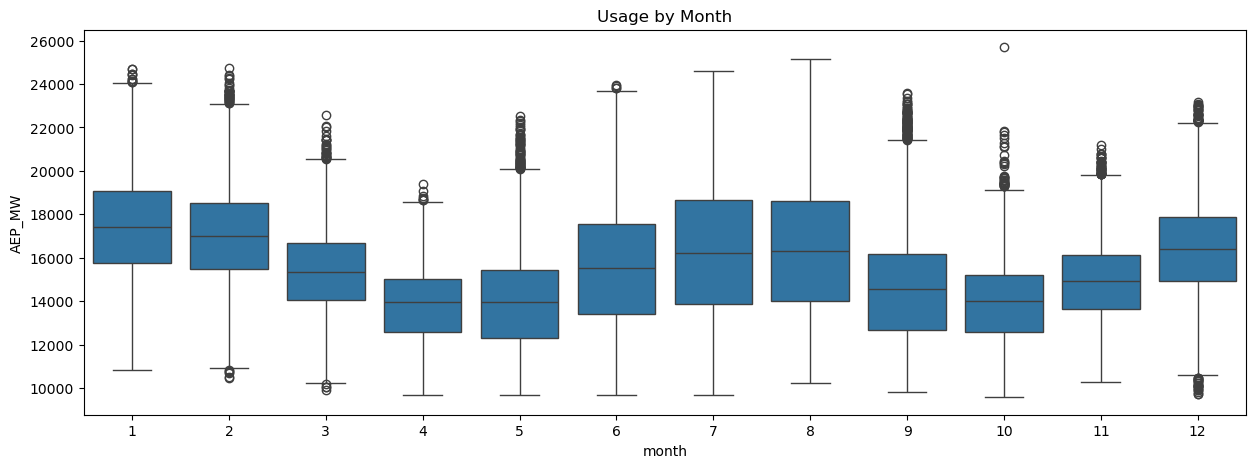

In [122]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x="month", y="AEP_MW")
ax.set_title("Usage by Month")

Text(0.5, 1.0, 'Usage by Quarter')

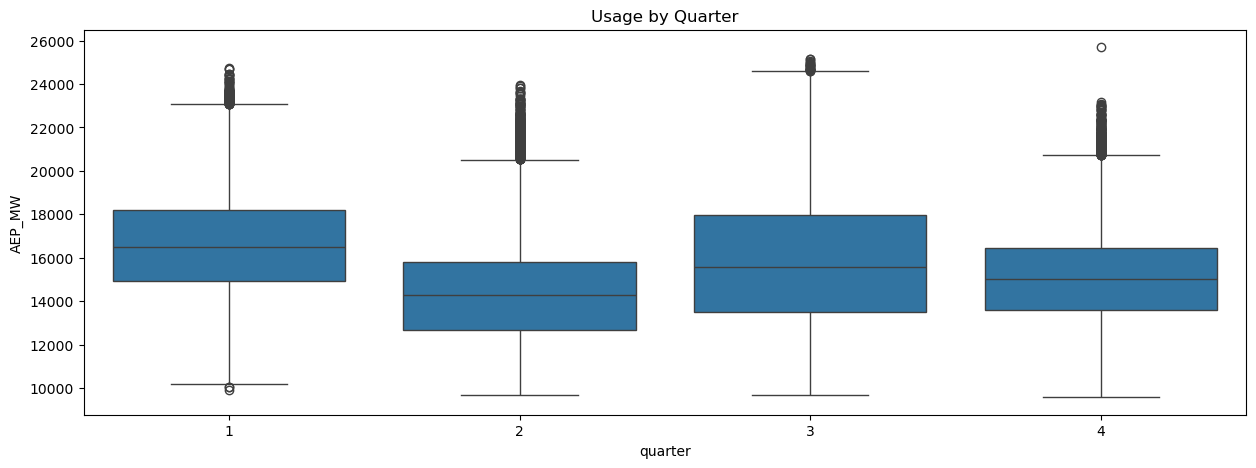

In [123]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x="quarter", y="AEP_MW")
ax.set_title("Usage by Quarter")

From the above graphs we can see that the usage peapeaks during winter and summer seasons (most likely during cooling and heating), and dips in between. There usage by quarter shows a more zoomed out picture of this trend.

### Model

In [124]:
# We want to make sure we bring in the new features we extracted into our train and test sets
train = feature_extraction(train)
test = feature_extraction(test)

In [125]:
df.columns

Index(['AEP_MW', 'hour', 'day_of_week', 'quarter', 'month', 'year',
       'day_of_year', 'day', 'christmas', 'halloween', 'fourth_of_july',
       'thanksgiving', 'easter'],
      dtype='object')

In [126]:
FEATURES = [
    "hour",
    "day_of_week",
    "quarter",
    "month",
    "year",
    "day_of_year",
    "day",
    "christmas",
    "halloween",
    "fourth_of_july",
    "thanksgiving",
    "easter",
]
TARGET = ["AEP_MW"]

In [127]:
# Divide the "train" data into X_train and y_train
X_train = train[FEATURES]
y_train = train[TARGET]

# Divide the "test" data into X_test and y_test
X_test = test[FEATURES]
y_test = test[TARGET]

In [128]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-rmse:2131.56898	validation_1-rmse:2232.07094
[1]	validation_0-rmse:1859.21590	validation_1-rmse:2026.06118
[2]	validation_0-rmse:1672.38447	validation_1-rmse:1871.44490
[3]	validation_0-rmse:1556.27210	validation_1-rmse:1826.22042
[4]	validation_0-rmse:1463.39345	validation_1-rmse:1784.65470
[5]	validation_0-rmse:1398.33102	validation_1-rmse:1777.26588
[6]	validation_0-rmse:1346.53797	validation_1-rmse:1759.39269
[7]	validation_0-rmse:1313.88115	validation_1-rmse:1749.37595
[8]	validation_0-rmse:1266.14572	validation_1-rmse:1757.17988
[9]	validation_0-rmse:1253.05085	validation_1-rmse:1756.10854
[10]	validation_0-rmse:1206.05729	validation_1-rmse:1753.91609
[11]	validation_0-rmse:1190.50229	validation_1-rmse:1748.95702
[12]	validation_0-rmse:1166.36054	validation_1-rmse:1752.47887
[13]	validation_0-rmse:1160.32730	validation_1-rmse:1752.28671
[14]	validation_0-rmse:1141.26562	validation_1-rmse:1744.02240
[15]	validation_0-rmse:1129.94539	validation_1-rmse:1739.99138
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

### Here we see that on the left (training set), the rmse starts to improve as we scroll down. However, on the right, even though it starts to decrease for a bit, it then starts to go back up. This means that the model is overfitting, and this is something that we want to avoid.

In [129]:
# Try the same thing as above, but lower the learning rate, and change "verbose" to 100
# Notice that it stops once the rmse on the right starts to increase

# Setting verbose=100 means that we will only get the rmse score for every 100 trees.
# This will make the results easier to read
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:2572.63794	validation_1-rmse:2614.76857
[100]	validation_0-rmse:1679.31372	validation_1-rmse:1891.66858
[200]	validation_0-rmse:1390.13943	validation_1-rmse:1753.14041
[300]	validation_0-rmse:1265.60783	validation_1-rmse:1725.14496
[363]	validation_0-rmse:1203.58437	validation_1-rmse:1726.42273


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [130]:
reg.feature_importances_

array([0.30611363, 0.14614756, 0.13644964, 0.10179561, 0.0447276 ,
       0.12834705, 0.02071595, 0.03535037, 0.        , 0.02531533,
       0.0499144 , 0.0051227 ], dtype=float32)

In [131]:
# Let's make the feature importance look a bit nicer.
# The above isn't too abrasive to look at, but can get confusing with more columns
feature_importance = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["importance_ranking"],
)

In [132]:
feature_importance.sort_values(by="importance_ranking")

,importance_ranking
halloween,0.000000
easter,0.005123
day,0.020716
fourth_of_july,0.025315
christmas,0.035350
year,0.044728
thanksgiving,0.049914
month,0.101796
day_of_year,0.128347
quarter,0.136450


We can conclude that the biggest changes happen hourly, and that the year and the various holidays don't influence the consumption too much. We can at least safely drop "halloween" and "easter"

### Forcast on Test Set

In [133]:
test["prediction"] = reg.predict(X_test)
test["prediction"]

Datetime
2016-01-01 00:00:00    16056.087891
2016-12-31 01:00:00    12231.712891
2016-12-31 02:00:00    11979.170898
2016-12-31 03:00:00    11926.778320
2016-12-31 04:00:00    11926.778320
                           ...     
2018-01-01 20:00:00    18034.806641
2018-01-01 21:00:00    18034.806641
2018-01-01 22:00:00    17999.982422
2018-01-01 23:00:00    17385.804688
2018-01-02 00:00:00    16039.303711
Name: prediction, Length: 22680, dtype: float32

In [134]:
# In order to see the predictions next to all the training data, we will merge
df = df.merge(test["prediction"], how="left", left_index=True, right_index=True)
df.tail()

,AEP_MW,hour,day_of_week,quarter,month,year,day_of_year,day,christmas,halloween,fourth_of_july,thanksgiving,easter,prediction
Datetime,,,,,,,,,,,,,,
2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1,1,0,0,0,0,0,18034.806641
2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1,1,0,0,0,0,0,18034.806641
2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1,1,0,0,0,0,0,17999.982422
2018-01-01 23:00:00,20415.0,23,0,1,1,2018,1,1,0,0,0,0,0,17385.804688
2018-01-02 00:00:00,19993.0,0,1,1,1,2018,2,2,0,0,0,0,0,16039.303711


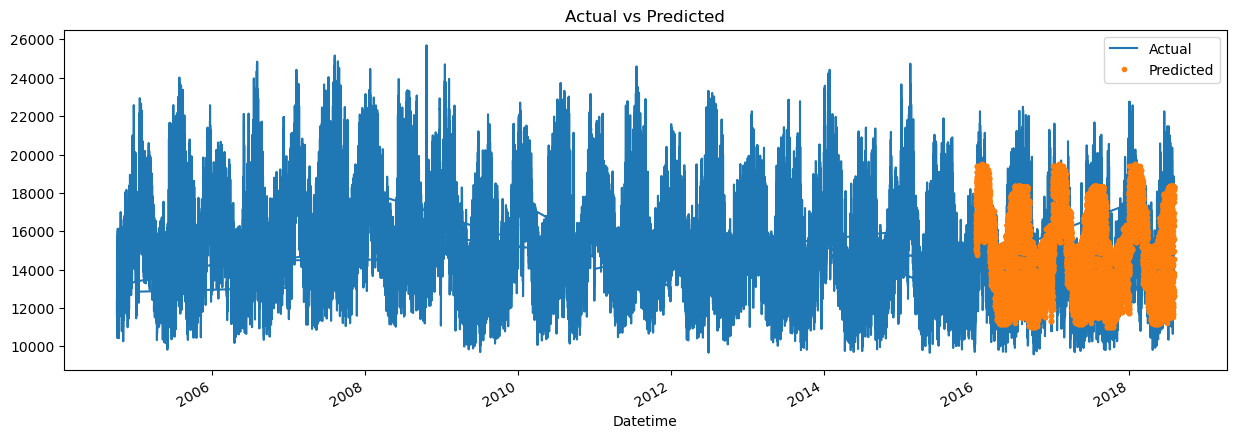

In [135]:
# ***Adjust this graph to only show data from 2014 up***
ax = df["AEP_MW"].plot(figsize=(15, 5))
df["prediction"].plot(ax=ax, style=".")
plt.legend(["Actual", "Predicted"])
ax.set_title("Actual vs Predicted")
plt.show()

The graphs shows the mode's accuracy compared to the actual wattage usage for the 2016 - 2018 time period. We can see that while certain high and low points weren't predicted accurately, the general trend was captured relatively well

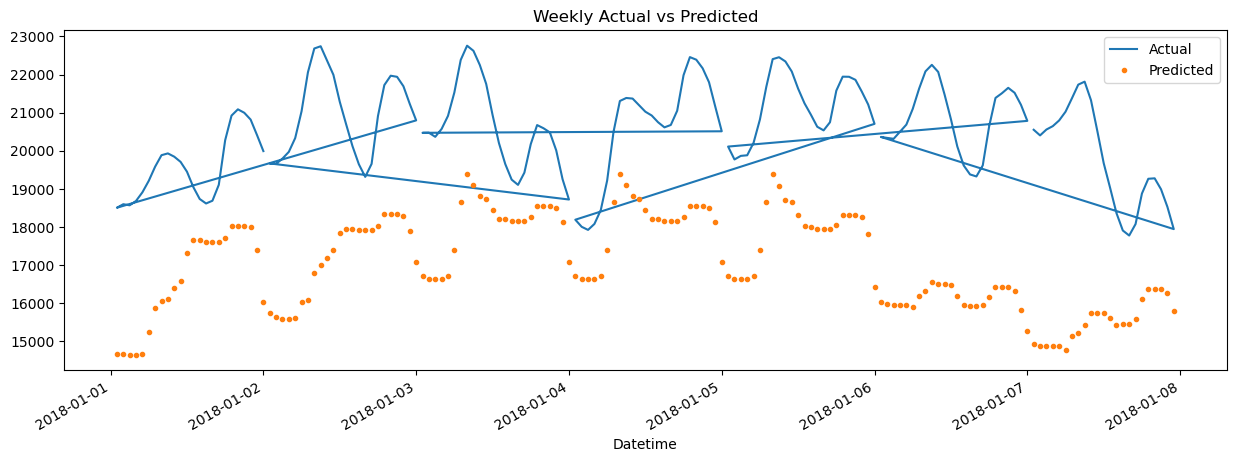

In [136]:
ax = df.loc[(df.index > "01-01-2018") & (df.index < "01-08-2018")]["AEP_MW"].plot(
    figsize=(15, 5), title="One Week Data Segment"
)
df.loc[(df.index > "01-01-2018") & (df.index < "01-08-2018")]["prediction"].plot(
    style="."
)
plt.legend(["Actual", "Predicted"])
ax.set_title("Weekly Actual vs Predicted")
plt.show()

### Interpreting The Results

In [137]:
score = np.sqrt(mean_squared_error(test["AEP_MW"], test["prediction"]))
print("RMSE Score on the Test Set is: ", score.round(2))

RMSE Score on the Test Set is:  1723.86


In [139]:
# Worst predicted days
test["error"] = np.abs(test[TARGET]["AEP_MW"] - test["prediction"])
test["date"] = test.index.date
test.groupby(["date"])["error"].mean().sort_values(ascending=False).head()

date
2017-12-28    5155.691366
2017-12-31    5089.860636
2018-01-06    4670.165487
2016-12-16    4580.062134
2017-02-24    4549.608398
Name: error, dtype: float64

In [140]:
# Best predicted days
test["error"] = np.abs(test[TARGET]["AEP_MW"] - test["prediction"])
test["date"] = test.index.date
test.groupby(["date"])["error"].mean().sort_values(ascending=True).head()

date
2016-12-03    232.259644
2018-08-03    278.683594
2017-03-18    286.176961
2017-12-23    292.141073
2017-07-27    292.714437
Name: error, dtype: float64

#### The worst predicted days occured in winter, in December, January, and February

## *TO-DO:* Cross-Validation/Fine Tuning

Try running the same model using Meta's Prophet